In [1]:
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd
import sharedstreets.tile
import mercantile
from shapely.geometry import Point, shape, MultiPoint
from functools import partial
import pyproj
from shapely.ops import transform, nearest_points

#references
https://platform.sharedstreets.io/40.71297/-74.00428/17.117/
https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html
https://automating-gis-processes.github.io/2017/lessons/L3/nearest-neighbour.html

# download the street map from OSM

In [2]:
# polygon boundry
client_ploys_gdf = gpd.read_file("GIS/TAZOfficialWCurrentForecasts.shp")

In [3]:
# project to lat-long
polygon_df_new = client_ploys_gdf.to_crs(epsg = 4326)

In [4]:
# get street network from polygon
G = ox.graph_from_polygon(polygon_df_new['geometry'].unary_union, network_type='drive')

#plot street network
#ox.plot_graph(G)

In [5]:
# save network as shapefile, two one-way links will be merged as one two-way link
# will help in runtime
#ox.save_graph_shapefile(G, filename='network-shape_MetCouncil')

# Read local Client network

In [6]:
# read shapefile as geopandas df
abm_edges_gdf = gpd.read_file("GIS/existing_client_network/base_network_link.shp")
abm_edges_gdf.crs = {'init' :'epsg:26915'}
abm_edges_gdf = abm_edges_gdf.to_crs(epsg = 4326)
abm_edges_gdf['mid_point'] = abm_edges_gdf['geometry'].interpolate(0.5, normalized = True)
abm_edges_gdf.shape

(57213, 35)

# Getting SharedStreets

In [7]:
# generate a GeoJSON which represents the parsed protobuf vector tiles from SharedStreets, 
# representing all tiles related to the networkx

def generate_geojson_of_coverage_area_streets(G, z=12, buffer_size = 0.015):
    geojson_master = None
    for mt in _generate_tile_coordinates(G, z, buffer_size):
        tile = sharedstreets.tile.get_tile(z, mt.x, mt.y)
        geojson = sharedstreets.tile.make_geojson(tile)

        if geojson_master is None:
            geojson_master = geojson

        else:
            # Updates both the features and references keys
            for key in ['features', 'references']:
                fs = _filter_new_objects(geojson_master, geojson, key)
                geojson_master[key].extend(fs)
    return geojson_master



def _generate_tile_coordinates(G, z, buffer_size = 0.015):
    '''
    :G: is either a networkX graph instance or a tuple of lat/long
    :z: is zoom level. Default is 12
    :buffer_size: is in degrees. Default: 0.015 is approx 1 mile, 0.03 is about 2 miles
    # parts of this are from http://kuanbutts.com/2018/06/07/sharedstreets-explore/
    # convert lat-long to XYZ tiles, use mercantile, https://media.readthedocs.org/pdf/mercantile/latest/mercantile.pdf
    '''
    mts = []
    for i, n in list(G.nodes(data=True)):
        # Now perform a buffer around the node points
        # to get a rough estimate of everything within
        # about 1 miles of the node
        p = Point(n['x'], n['y'])
        bp = p.buffer(buffer_size)  
        bpe = bp.simplify(0.005).exterior
        for x, y in zip(*bpe.coords.xy):
            mt = mercantile.tile(x, y, z)
            mts.append(mt)

    # Dedupe results
    return set(mts)


def _filter_new_objects(master, new_gj, key):
    keep = []
    gm_ids = [f['id'] for f in master[key]]
    for f2 in new_gj[key]:
        if f2['id'] not in gm_ids:
            keep.append(f2)
    return keep

In [8]:
# Generate a GeoJSON Feature Collection of the total coverage area, 1hr to run for the Met Council Core region
ssgj = generate_geojson_of_coverage_area_streets(G)

# Tag SSID to existing OSM graph

In [9]:
# creating a look up from the reference to the geometries
geometry_lookup = {}
for feature in ssgj['features']:
    i = feature['id']
    geometry_lookup[i] = feature
    
shaped_references = []
for r in ssgj['references']:
    feature = geometry_lookup[r['geometryId']]
    r['feature'] = feature
    
    # Also convert all distances to meter from centimeter
    for lr in r['locationReferences']:
        d = lr['distanceToNextRef']
        if d is not None:
            lr['distanceToNextRef'] = d/100.0

    shaped_references.append(r)

In [22]:
# Create the sharestreets edges geo dataframe
ss_edges = []
for sr in shaped_references:
    # Only do for direct edges (which should be all)
    if len(sr['locationReferences']) == 2:
        lrs = sr['locationReferences']
        if lrs[0]['sequence'] == 0:
            first = 0
            last = 1
        else:
            first = 1
            last = 0
            
        lrs = sr['locationReferences']
        fr = lrs[first]['intersectionId']
        to = lrs[last]['intersectionId']
        d = lrs[first]['distanceToNextRef']
        ss_edges.append({
            'id': sr['id'],
            'from': fr,
            'to': to,
            'length': d,
            'geometry': shape(sr['feature']['geometry'])
        })

    # This should not ever happen
    else:
        # Could actually use logger instead of a print statement
        print('Skipped an edge - not length 2')
        
ss_edges_df = pd.DataFrame(ss_edges)
ss_edges_df = ss_edges_df.drop_duplicates(subset=['id'], keep='first')
ss_edges_gdf = gpd.GeoDataFrame(ss_edges_df, geometry=ss_edges_df.geometry)

ss_edges_gdf['mid_point'] = ss_edges_gdf['geometry'].interpolate(0.5, normalized = True)
ss_edges_gdf.shape

(458030, 6)

In [43]:
# Reproject project in equal area meter
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),  # source coordinate system
    pyproj.Proj(init='epsg:2163'))  # destination coordinate system

ss_edges_gdf_reproj = ss_edges_gdf.copy()
ss_edges_gdf_reproj['geometry'] = ss_edges_gdf_reproj['geometry'].apply(lambda g: transform(project, g))

In [44]:
ss_edges_gdf_reproj

,from,geometry,id,length,to,mid_point
0,4862d20b49ed6e475cae0199a0095f99,LINESTRING (506767.950616708 -39302.7698978834...,a9dc4adf4df55241d9a13706c8806eb5,748.83,2d8be663a19e22ad226137c6533a5134,POINT (-93.61000588911915 44.46794292681646)
1,2d8be663a19e22ad226137c6533a5134,LINESTRING (506767.950616708 -39302.7698978834...,36efd90e01ae6d8f3fe1c34fc871453c,748.83,4862d20b49ed6e475cae0199a0095f99,POINT (-93.61000588911915 44.46794292681646)
2,c099da1948144fd7ac958eb500719ddb,LINESTRING (506588.0190864702 -37171.690392732...,40e23c56ea84bd3de66632b21757ea26,1610.99,730571e31a5ede5f827f241e288cd656,POINT (-93.60591505678671 44.49341423246791)
3,730571e31a5ede5f827f241e288cd656,LINESTRING (506588.0190864702 -37171.690392732...,984ba6e5505413011858c2d6c58e78e4,1610.99,c099da1948144fd7ac958eb500719ddb,POINT (-93.60591505678671 44.49341423246791)
4,2b7ccffe847102c68ab277b54afdeabc,LINESTRING (501532.2575900269 -34362.157482996...,a73729951384c71358132c161341c089,1631.41,615f47b36eb661a9508a23f7f55067b6,POINT (-93.67696121479491 44.51482361829252)
5,615f47b36eb661a9508a23f7f55067b6,LINESTRING (501532.2575900269 -34362.157482996...,c2a89b4a671ac00c4307044409eacea1,1631.41,2b7ccffe847102c68ab277b54afdeabc,POINT (-93.67696121479491 44.51482361829252)
6,7ef9b94af2a7384aa24b9dc3ebfacc73,LINESTRING (500195.5223313035 -37711.070171167...,804d68b138908fc5eebfb08a16bddddb,1611.64,fc6e8d35943c905e8264d5157310e716,POINT (-93.6867403576192 44.4785772883372)
7,fc6e8d35943c905e8264d5157310e716,LINESTRING (500195.5223313035 -37711.070171167...,32bfb51be49b671c94b9ebb2af719a8d,1611.64,7ef9b94af2a7384aa24b9dc3ebfacc73,POINT (-93.6867403576192 44.4785772883372)
8,b12429d22c0544a30fec51e7f4539325,LINESTRING (501660.5886884161 -35967.930446975...,941544129d727d0aa0d14d421da76ce4,1611.32,64afb324b5e1f591f2ec7d23e0362e4b,POINT (-93.66655751600786 44.49317110594795)
9,64afb324b5e1f591f2ec7d23e0362e4b,LINESTRING (501660.5886884161 -35967.930446975...,dea5c06fb7815464b66012854ed78092,1611.32,b12429d22c0544a30fec51e7f4539325,POINT (-93.66655751600786 44.49317110594795)


In [12]:
#ss_edges_gdf.drop('mid_point', axis = 1).to_file("data/metcouncil_ss.shp")

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [45]:
abm_edges_gdf

,A,B,COUNTY,T_PRIORITY,T_MANTIME,DISTANCE,TLGID,NC_SPD,NC_NAME,TOM,...,LANES15,LANES40,CENTROID,RC_NUM,FUN_CLASS,SHAPE_LENGT,GEOMETRYSOU,geometry,mid_point,id
0,1,54632,1,0,0.0,0.94913,0,0,None,0,...,1,1,1,99,0,1527.47205,1,LINESTRING (-93.47971291682903 45.399203746856...,POINT (-93.46995609177307 45.39931294127314),0
1,2,29402,1,0,0.0,0.54824,0,0,None,0,...,1,1,1,99,0,882.31226,1,LINESTRING (-93.40351201927371 45.407004597157...,POINT (-93.40221450963682 45.40314029858216),1
2,2,54633,1,0,0.0,0.64614,0,0,None,0,...,1,1,1,99,0,1039.86682,1,LINESTRING (-93.40351201927371 45.407004597157...,POINT (-93.4089753667255 45.40434167944774),2
3,3,29331,1,0,0.0,1.07559,0,0,None,0,...,1,1,1,99,0,1730.99902,1,LINESTRING (-93.42928119063902 45.394007578642...,POINT (-93.43963609531933 45.39674078932475),3
4,3,29390,1,0,0.0,0.75921,0,0,None,0,...,1,1,1,99,0,1221.82654,1,LINESTRING (-93.42928119063902 45.394007578642...,POINT (-93.42473159531937 45.39847578932482),4
5,3,29395,1,0,0.0,1.38379,0,0,None,0,...,1,1,1,99,0,2226.99561,1,LINESTRING (-93.42928119063902 45.394007578642...,POINT (-93.41663659531949 45.38941678932486),5
6,4,29395,1,0,0.0,0.80511,0,0,None,0,...,1,1,1,99,0,1295.70532,1,LINESTRING (-93.39014834405843 45.391218844058...,POINT (-93.3970701720292 45.38802242203286),6
7,4,29404,1,0,0.0,0.62411,0,0,None,0,...,1,1,1,99,0,1004.41559,1,LINESTRING (-93.39014834405843 45.391218844058...,POINT (-93.3930976720292 45.3952334220329),7
8,4,29429,1,0,0.0,0.46713,0,0,None,0,...,1,1,1,99,0,751.77502,1,LINESTRING (-93.39014834405843 45.391218844058...,POINT (-93.38675217202908 45.39361092203285),8
9,5,29431,1,0,0.0,0.27038,0,0,None,0,...,1,1,1,99,0,435.13095,1,LINESTRING (-93.3743616932517 45.3944679681328...,POINT (-93.37640384662581 45.39313948406991),9


In [13]:
def nearest(row, geom_union, df1, df2, geom1_col, geom2_col, src_column=None):
    """Find the nearest point and return the corresponding value from specified column."""
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].get_values()[0]
    return value

#unary_union = ss_edges_gdf['mid_point'].unary_union
unary_union = MultiPoint(ss_edges_gdf['mid_point'])

#usingNearestNode function, but this is slow as it considers the entire ss set
abm_edges_gdf_sub['ss_id'] = abm_edges_gdf_sub.apply(nearest, 
                                        geom_union = unary_union, 
                                        df1 = abm_edges_gdf_sub, 
                                        df2 = ss_edges_gdf, 
                                        geom1_col = 'mid_point', 
                                        geom2_col = 'mid_point',
                                        src_column='id', 
                                        axis=1)

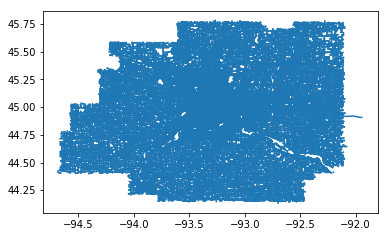

In [69]:
ss_edges_gdf.plot()

In [85]:
#>24hrs to run for client network
nodes_to_consider = []
for i, node in zip(abm_edges_gdf['id'], abm_edges_gdf['mid_point']):
    node_p = transform(project, node)  # apply projection
    nodes_to_consider.append((i, node_p))

print('Eval {} nodes'.format(len(nodes_to_consider)))

def min_dist(point, gdf, max_d):
    # Get all possible road segments that are within 20 meters of the node
    gdf_sub = gdf[gdf.intersects(point.buffer(800))]
    gdf_sub = gdf_sub.reset_index(drop=True)
    
    # Calculate the shortest distance to all these subset segments    
    dists = []
    for geom in gdf_sub.geometry:
        d = point.distance(geom)
        dists.append(d)
        
    # Bail early if nothing to compare with
    if len(dists) == 0:
        return None
    
    # Note: min_dist is in meters
    dists = np.array(dists)
    dm = dists.min()
    
    # Do not allow "too-far" distances
    if dm > max_d:
        return None
    
    # Otherwise return the smallest distance row
    row = gdf_sub.iloc[dists == dm].head(1).squeeze()
    distance_along = row.geometry.project(point)
    return {
        'row': row,
        #'distance_along': distance_along,
        #'percentage_along': distance_along/row.geometry.length
    }

assoc_segments = []
for i, node_p in nodes_to_consider:
    if (i%2000 == 0):
        print(i)
    closest = min_dist(node_p, ss_edges_gdf_reproj, 1000)

    # Only if there is one found
    if closest is not None:
        g = closest['row'].geometry
        ss_id = closest['row']['id']
        #fr_ss_id = closest['row']['from']
        #to_ss_id = closest['row']['to']
        #distance_along = closest['distance_along']
        #percentage_along = closest['percentage_along']
    else:
        g = None
        ss_id = None
        #fr_ss_id = None
        #to_ss_id = None
        #distance_along = None
        #percentage_along = None
    assoc_segments.append({
        'abmid': i,
        #'osmid_from_node' : from_node,
        #'osmid_to_node' : to_node,
        'ssid_edge': ss_id,
        #'ssid_from': fr_ss_id,
        #'ssid_to': to_ss_id,
        'geometry': g#,
        #'distance_along': distance_along,
        #'percentage_along': percentage_along
    })

assoc_segments_df = pd.DataFrame(assoc_segments)
assoc_segments_gdf_meter = gpd.GeoDataFrame(assoc_segments_df, geometry=assoc_segments_df.geometry)

Eval 57213 nodes
0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000


In [83]:
abm_edges_gdf.shape

(57213, 36)

In [120]:
assoc_segments_gdf_latlong = assoc_segments_gdf_latlong[assoc_segments_gdf_latlong['geometry'].notnull()]
assoc_segments_gdf_latlong.crs = {'init' : 'epsg:2163'}
assoc_segments_gdf_latlong = assoc_segments_gdf_latlong.to_crs(epsg = 4326)

In [122]:
assoc_segments_gdf_latlong.shape

(57177, 3)

In [123]:
assoc_segments_gdf_meter.shape

(57213, 3)

In [125]:
abm_edges_gdf_with_ssid = pd.merge(abm_edges_gdf,
                                  assoc_segments_gdf_latlong.rename(columns = {"geometry" : "geometry_ss"}),
                                  left_on = 'id',
                                  right_on = 'abmid',
                                  how = 'left')
abm_edges_gdf_with_ssid

,A,B,COUNTY,T_PRIORITY,T_MANTIME,DISTANCE,TLGID,NC_SPD,NC_NAME,TOM,...,RC_NUM,FUN_CLASS,SHAPE_LENGT,GEOMETRYSOU,geometry,mid_point,id,abmid,geometry_ss,ssid_edge
0,1,54632,1,0,0.0,0.94913,0,0,None,0,...,99,0,1527.47205,1,LINESTRING (-93.47971291682903 45.399203746856...,POINT (-93.46995609177307 45.39931294127314),0,0.0,"LINESTRING (-93.47822700000002 45.397927, -93....",37ebb179f111320ad0ee71b94edc47fd
1,2,29402,1,0,0.0,0.54824,0,0,None,0,...,99,0,882.31226,1,LINESTRING (-93.40351201927371 45.407004597157...,POINT (-93.40221450963682 45.40314029858216),1,1.0,"LINESTRING (-93.401971 45.40532400000001, -93....",365dbd7876b592f042a6692ccc5840da
2,2,54633,1,0,0.0,0.64614,0,0,None,0,...,99,0,1039.86682,1,LINESTRING (-93.40351201927371 45.407004597157...,POINT (-93.4089753667255 45.40434167944774),2,2.0,"LINESTRING (-93.407709 45.40376400000002, -93....",70b0163517615bf13ead5aaf50febb6c
3,3,29331,1,0,0.0,1.07559,0,0,None,0,...,99,0,1730.99902,1,LINESTRING (-93.42928119063902 45.394007578642...,POINT (-93.43963609531933 45.39674078932475),3,3.0,LINESTRING (-93.44023300000001 45.383507000000...,b325ea38cc3107b7c0c96c68940a4180
4,3,29390,1,0,0.0,0.75921,0,0,None,0,...,99,0,1221.82654,1,LINESTRING (-93.42928119063902 45.394007578642...,POINT (-93.42473159531937 45.39847578932482),4,4.0,"LINESTRING (-93.418671 45.397862, -93.418571 4...",420ca49d6e87ba3ba3bb523c10a99415
5,3,29395,1,0,0.0,1.38379,0,0,None,0,...,99,0,2226.99561,1,LINESTRING (-93.42928119063902 45.394007578642...,POINT (-93.41663659531949 45.38941678932486),5,5.0,LINESTRING (-93.41528600000001 45.396644000000...,cfc7c9eb1760197c768523783281f557
6,4,29395,1,0,0.0,0.80511,0,0,None,0,...,99,0,1295.70532,1,LINESTRING (-93.39014834405843 45.391218844058...,POINT (-93.3970701720292 45.38802242203286),6,6.0,"LINESTRING (-93.403987 45.38480200000001, -93....",edbf15263b62fddb63c12ba47f8e9c3a
7,4,29404,1,0,0.0,0.62411,0,0,None,0,...,99,0,1004.41559,1,LINESTRING (-93.39014834405843 45.391218844058...,POINT (-93.3930976720292 45.3952334220329),7,7.0,"LINESTRING (-93.390081 45.395233, -93.39010399...",3fe3c9b4db62b1ce11c6fa912b678bc1
8,4,29429,1,0,0.0,0.46713,0,0,None,0,...,99,0,751.77502,1,LINESTRING (-93.39014834405843 45.391218844058...,POINT (-93.38675217202908 45.39361092203285),8,8.0,LINESTRING (-93.38712200000001 45.394433000000...,907d07f1ed660c34654bc248302132c3
9,5,29431,1,0,0.0,0.27038,0,0,None,0,...,99,0,435.13095,1,LINESTRING (-93.3743616932517 45.3944679681328...,POINT (-93.37640384662581 45.39313948406991),9,9.0,"LINESTRING (-93.377537 45.39597899999999, -93....",eaf53a4905a7e2b449c5be8b387b868a


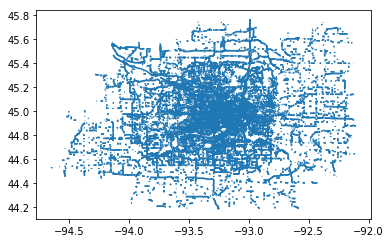

In [128]:
assoc_segments_gdf_latlong.plot()

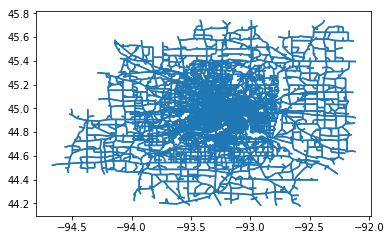

In [127]:
abm_edges_gdf_with_ssid.plot()

In [131]:
#writeout correspondence
abm_edges_gdf_with_ssid[['abmid', 'ssid_edge']].to_csv('data/ss_corresp/client_ss.csv')
abm_edges_gdf_with_ssid.drop(['mid_point', 'geometry_ss'], axis = 1).to_file("data/ss_corresp/paired_clientnet_ss.shp")

In [132]:
abm_edges_gdf_with_ssid.drop(['mid_point', 'geometry_ss'], axis = 1).to_file("data/ss_corresp/clientnet_ss.shp")

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
